In [2]:
# 数据分析
import pandas as pd 
import numpy as np
import pickle
from tqdm import *
from rqfactor import *
from scipy.stats import spearmanr

# 米筐
from rqdatac import *
init()

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [3]:
def get_Performance_analysis(T,year_day = 252):
    # 获取最终净值
    net_values = round(T[-1],4)
    
    # 计算几何年化收益率
    year_ret_sqrt = net_values**(year_day/len(T))-1
    year_ret_sqrt = round(year_ret_sqrt*100,2)
    
    # 计算年化波动率
    volitiy = T.pct_change().dropna().std()*np.sqrt(year_day)
    volitiy = round(volitiy*100,2)
    
    #计算夏普，无风险收益率记3%
    Sharpe = (year_ret_sqrt - 3)/volitiy
    Sharpe = round(Sharpe,2)

    # 计算最大回撤
    # 最大回撤结束点
    i = np.argmax((np.maximum.accumulate(T) - T)/np.maximum.accumulate(T))
    # 开始点
    j = np.argmax(T[:i])

    downlow = round((1-T[i]/T[j])*100,2)

    # 输出
    return [net_values,year_ret_sqrt,Sharpe,downlow,volitiy]

#### 基础设定

In [4]:
start_date = '2018-01-01'
end_date = '2023-06-01'

universe = '000300.XSHG'

# 动态券池
def INDEX_FIX(start_date,end_date,index_item):
    """
    :param start_date: 开始日 -> str
    :param end_date: 结束日 -> str 
    :param index_item: 指数代码 -> str 
    :return index_fix: 动态因子值 -> unstack
    """
    
    index = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in index_components(index_item,start_date= start_date,end_date=end_date).items()])).T

    # 构建动态股票池 
    index_fix = index.unstack().reset_index().iloc[:,-2:]
    index_fix.columns = ['date','stock']
    index_fix.date = pd.to_datetime(index_fix.date)
    index_fix['level'] = True
    index_fix.dropna(inplace = True)
    index_fix = index_fix.set_index(['date','stock']).level.unstack()
    index_fix.fillna(False,inplace = True)

    return index_fix

index_fix = INDEX_FIX(start_date,end_date,universe)
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

In [5]:
month_date_list = get_trading_dates(start_date,end_date)

month_list = []

for i in range(1,len(month_date_list)):
    if month_date_list[i-1].month != month_date_list[i].month:
        month_list.append(month_date_list[i-1])

month_list = pd.to_datetime(month_list)

#### BARRA数据获取

In [7]:
barra_style = ['momentum','beta','book_to_price','earnings_yield','liquidity','size','residual_volatility','non_linear_size','leverage','growth']

In [8]:
barra_dict = pd.read_pickle('./data/barra_dict.pkl')

In [9]:
barra_return = pd.read_pickle('./data/barra_return.pkl')

<Axes: xlabel='date'>

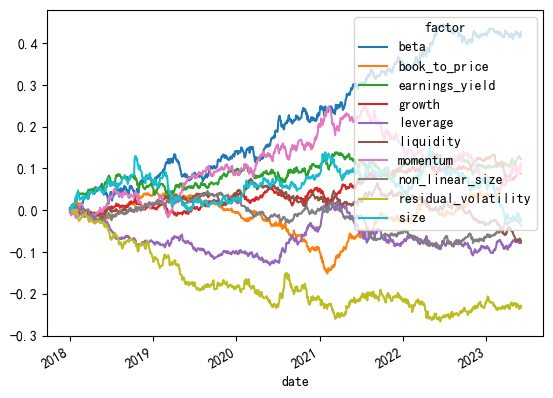

In [10]:
barra_return.cumsum().plot()

#### 风险因子构建

##### （1）估值价差

VALUATION SPREAD 
Because large amounts of capital chasing a group of securities will result in them becoming more expensive than others that are not as crowded, valuation spread is an intuitively appealing metric. In our model, this metric measures the degree to which the top quintile stocks of a factor are expensive relative to the bottom quintile. The valuation spread measure of crowdedness will increase as top quintile stocks become more expensive relative to bottom quintile stocks. Specifically, we calculate the median B/P, Sales/Price (S/P) and forecast E/P among both the top and bottom quintile stocks of a factor, and then calculate the ratio or difference between the two. For B/P, we calculate the natural log of the ratio of 

(median B/P in bottom quintile of factor) / (median B/P in top quintile of factor)

In this formulation, large positive values are associated with relatively high degrees of crowding in the factor, as the denominator will be small relative to the numerator. We use the ratio of bottom quintile B/P to top quintile B/P, rather than the arithmetic difference,because the difference will be sensitive to overall market valuations, but the ratio will not.We use the same formulation with the S/P valuation ratio. However, because earnings yield can theoretically become negative or near zero, we use the difference for the forecast E/P valuation ratio. Specifically, we calculate 

(median E/P in bottom quintile of factor) - (median E/P in top quintile of factor) 

We standardize each valuation spread using its own cumulative time series up to the given time, and then take the equal-weighted average of the three as the valuation spread metric for a given factor. We use median values rather than the mean, to prevent outliers from significantly influencing the standardization process. This is particularly important for B/P and earnings yield. Exhibit 1 below plots the correlations between the valuation metric and future factor returns and volatility.

In [11]:
ep = execute_factor(Factor('ep_ratio_ttm'),stock_list,start_date,end_date).mask(~index_fix)
bp = execute_factor(Factor('book_to_market_ratio_lf'),stock_list,start_date,end_date).mask(~index_fix)

##### EP的十分组和五分组的对比

In [18]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.8,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.2,axis = 1),axis = 0) > 0)

# 盈市率
ep_spread =  ep.mask(momentum_top.isnull()).median(axis = 1) - ep.mask(momentum_bottom.isnull()).median(axis = 1)
ep_spread_z60 = ((ep_spread - ep_spread.rolling(60).mean())/ep_spread.rolling(60).std())
ep_spread_z120 = ((ep_spread - ep_spread.rolling(120).mean())/ep_spread.rolling(120).std())
ep_spread_z240 = ((ep_spread - ep_spread.rolling(240).mean())/ep_spread.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([ep_spread.to_frame('crowd'),ep_spread_z60.to_frame('crowd_z60'),ep_spread_z120.to_frame('crowd_z120'),ep_spread_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.554262,0.665610,0.711329,-0.268516,-0.241213,-0.238559
crowd_z60,0.554262,1.000000,0.858981,0.750867,0.126445,-0.089819,-0.102933
crowd_z120,0.665610,0.858981,1.000000,0.923309,0.229199,-0.132840,-0.155653
crowd_z240,0.711329,0.750867,0.923309,1.000000,0.374200,-0.212825,-0.326482
mon_cumret,-0.268516,0.126445,0.229199,0.374200,1.000000,-0.220319,-0.443381
mom_ret20,-0.241213,-0.089819,-0.132840,-0.212825,-0.220319,1.000000,0.586361
mom_ret60,-0.238559,-0.102933,-0.155653,-0.326482,-0.443381,0.586361,1.000000


<Axes: title={'center': '十分组_拥挤度_EP估值价差系数_分层收益'}, xlabel='crowd_group'>

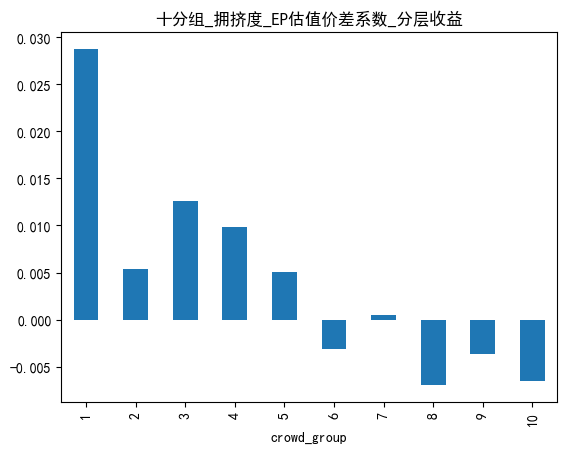

In [20]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '十分组_拥挤度_EP估值价差系数_分层收益')

In [14]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.9,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.1,axis = 1),axis = 0) > 0)

# 盈市率
ep_spread =  ep.mask(momentum_top.isnull()).median(axis = 1) - ep.mask(momentum_bottom.isnull()).median(axis = 1)
ep_spread_z60 = ((ep_spread - ep_spread.rolling(60).mean())/ep_spread.rolling(60).std())
ep_spread_z120 = ((ep_spread - ep_spread.rolling(120).mean())/ep_spread.rolling(120).std())
ep_spread_z240 = ((ep_spread - ep_spread.rolling(240).mean())/ep_spread.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([ep_spread.to_frame('crowd'),ep_spread_z60.to_frame('crowd_z60'),ep_spread_z120.to_frame('crowd_z120'),ep_spread_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.532455,0.654486,0.777719,-0.050366,-0.216683,-0.287491
crowd_z60,0.532455,1.000000,0.841712,0.719292,-0.007034,0.003379,0.008928
crowd_z120,0.654486,0.841712,1.000000,0.917237,0.109446,-0.022572,-0.089304
crowd_z240,0.777719,0.719292,0.917237,1.000000,0.208644,-0.097574,-0.233649
mon_cumret,-0.050366,-0.007034,0.109446,0.208644,1.000000,-0.220319,-0.443381
mom_ret20,-0.216683,0.003379,-0.022572,-0.097574,-0.220319,1.000000,0.586361
mom_ret60,-0.287491,0.008928,-0.089304,-0.233649,-0.443381,0.586361,1.000000


<Axes: title={'center': '五分组_拥挤度_EP估值价差系数_分层收益'}, xlabel='crowd_group'>

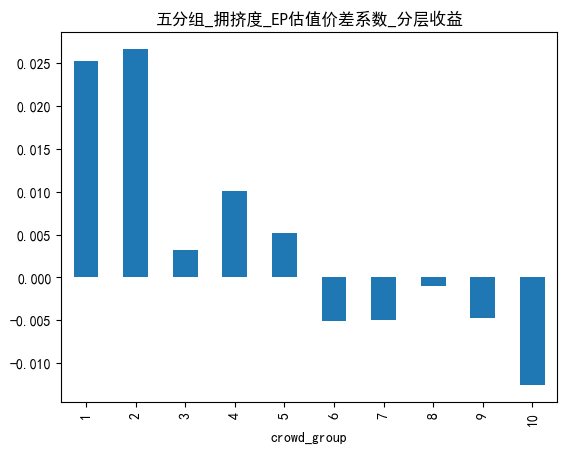

In [17]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '五分组_拥挤度_EP估值价差系数_分层收益')

##### 对比BP的比值对数和BP相减

In [21]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.8,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.2,axis = 1),axis = 0) > 0)

# 市净率
bp_spread = np.log(bp.mask(momentum_bottom.isnull()).median(axis = 1)/bp.mask(momentum_top.isnull()).median(axis = 1))
bp_spread_z60 = ((bp_spread - bp_spread.rolling(60).mean())/bp_spread.rolling(60).std())
bp_spread_z120 = ((bp_spread - bp_spread.rolling(120).mean())/bp_spread.rolling(120).std())
bp_spread_z240 = ((bp_spread - bp_spread.rolling(240).mean())/bp_spread.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([bp_spread.to_frame('crowd'),bp_spread_z60.to_frame('crowd_z60'),bp_spread_z120.to_frame('crowd_z120'),bp_spread_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.384245,0.439753,0.596257,0.478668,0.199716,0.174463
crowd_z60,0.384245,1.000000,0.853559,0.708344,-0.166105,0.173488,0.100208
crowd_z120,0.439753,0.853559,1.000000,0.887624,-0.260987,0.155638,0.106418
crowd_z240,0.596257,0.708344,0.887624,1.000000,-0.200170,0.172188,0.207499
mon_cumret,0.478668,-0.166105,-0.260987,-0.200170,1.000000,-0.220319,-0.443381
mom_ret20,0.199716,0.173488,0.155638,0.172188,-0.220319,1.000000,0.586361
mom_ret60,0.174463,0.100208,0.106418,0.207499,-0.443381,0.586361,1.000000


<Axes: title={'center': '五分组_拥挤度_BP对数估值价差系数_分层收益'}, xlabel='crowd_group'>

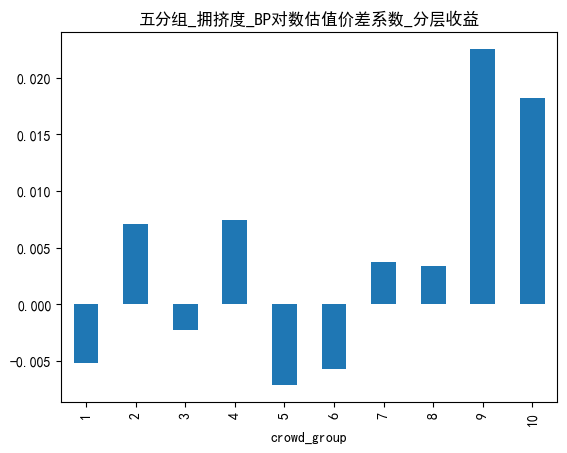

In [22]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '五分组_拥挤度_BP对数估值价差系数_分层收益')

In [23]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.8,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.2,axis = 1),axis = 0) > 0)

# 市净率
bp_spread = bp.mask(momentum_top.isnull()).median(axis = 1) - bp.mask(momentum_bottom.isnull()).median(axis = 1)
bp_spread_z60 = ((bp_spread - bp_spread.rolling(60).mean())/bp_spread.rolling(60).std())
bp_spread_z120 = ((bp_spread - bp_spread.rolling(120).mean())/bp_spread.rolling(120).std())
bp_spread_z240 = ((bp_spread - bp_spread.rolling(240).mean())/bp_spread.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([bp_spread.to_frame('crowd'),bp_spread_z60.to_frame('crowd_z60'),bp_spread_z120.to_frame('crowd_z120'),bp_spread_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.401085,0.526985,0.661688,-0.317405,-0.270371,-0.303478
crowd_z60,0.401085,1.000000,0.872685,0.713482,0.231977,-0.183735,-0.128303
crowd_z120,0.526985,0.872685,1.000000,0.902966,0.297554,-0.239067,-0.183389
crowd_z240,0.661688,0.713482,0.902966,1.000000,0.235079,-0.187604,-0.205465
mon_cumret,-0.317405,0.231977,0.297554,0.235079,1.000000,-0.220319,-0.443381
mom_ret20,-0.270371,-0.183735,-0.239067,-0.187604,-0.220319,1.000000,0.586361
mom_ret60,-0.303478,-0.128303,-0.183389,-0.205465,-0.443381,0.586361,1.000000


<Axes: title={'center': '五分组_拥挤度_BP减法估值价差系数_分层收益'}, xlabel='crowd_group'>

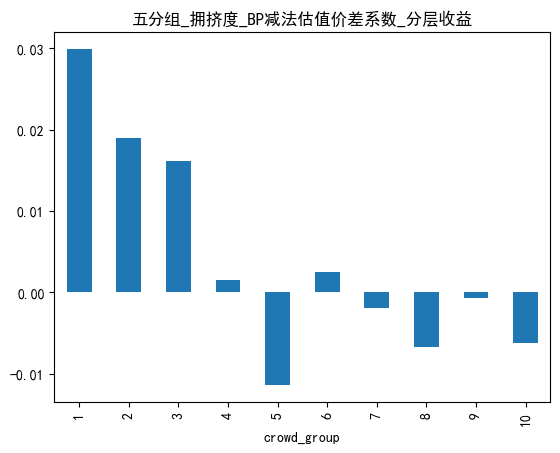

In [24]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '五分组_拥挤度_BP减法估值价差系数_分层收益')

##### （2）配对相关性

配对相关性从股票同涨同跌的特征来度量因子的拥挤程度。资金对于因子的追捧会加剧这一类股票同涨同跌的特性，因此配对相关性指标越大则因子越拥挤。

在截面观测日回看3个月，将多空头组合内的成分股日收益等权，计算多空组合的日收益。分别计算组内成分股和多空头组合的日收益相关系数，并取均值，计算多空头配对相关性。

+ 多头配对相关性 = Mean(Corr(个股 i3 个月, 多头组合均收益 3 个月))

+ 空头配对相关性 = Mean(Corr(个股 i3 个月, 空头组合均收益 3 个月))

+ 配对相关性指标 = 多头配对相关性 +空头配对相关性

总结：空头配对相关性对于空头的剥离效果较好，多头配对相关性对于多头剥离效果较好


PAIRWISE CORRELATION
This metric measures the degree to which stocks of the top or bottom quintile of a factor move together, after accounting for movements due to the market, size, beta and residual volatility factors. If a factor is being heavily followed by investors, stocks with very high 
exposures to the factor will, in theory, tend to move together, as will stocks with very low exposure to the factor. This will cause high average pairwise correlation. For this metric, we implemented the same formulation as described in Bayraktar et al. (2015a), which is based on the framework of Lou and Polk (2013).

In this metric, we select the top quintile securities of a factor and for each security we measure its correlation with the top quintile average return, excluding the individual stock, using the past 63 trading days of daily returns. We do the same for the bottom quintile. We 
use specific returns, accounting for the standard risk factors of market, size, beta and residual volatility. We calculate the average pairwise correlation of the top and bottom quintiles separately, and then take the average of the two quintiles to create the raw value

In [25]:
ret = get_price(stock_list,get_previous_trading_date(start_date,63),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')

In [26]:
specific_return = pd.read_pickle('data/specific_return.pkl')

In [27]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.8,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.2,axis = 1),axis = 0) > 0)

##### 对比特质收益率和资产收益率

In [28]:
match_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,63)
    end_date_temp = i
    # 多头组配对相关性
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret60 = specific_return.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    top_ret60['mean'] = top_ret60.mean(axis = 1)
    top_match = top_ret60.corr()['mean'].drop('mean').mean()
    # 空头组配对相关性
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret60 = specific_return.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    bottom_ret60['mean'] = bottom_ret60.mean(axis = 1)
    bottom_match = bottom_ret60.corr()['mean'].drop('mean').mean()

    match_dict[i] = {'top':top_match,'bottom':bottom_match}

match_df = pd.DataFrame(match_dict).T

100%|██████████| 1314/1314 [00:02<00:00, 446.53it/s]


In [29]:
match_df = pd.DataFrame(match_dict).T
match_df['match'] = (match_df['top'] + match_df['bottom'])/2
match = - match_df['match']

match_z60 = ((match - match.rolling(60).mean())/match.rolling(60).std())
match_z120 = ((match - match.rolling(120).mean())/match.rolling(120).std())
match_z240 = ((match - match.rolling(240).mean())/match.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([match.to_frame('crowd'),-match_df['top'].to_frame('crowd_top'),-match_df['bottom'].to_frame('crowd_bottom'),match_z60.to_frame('crowd_z60'),match_z120.to_frame('crowd_z120'),match_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_top,crowd_bottom,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.593724,0.723197,0.677376,0.871978,0.942385,-0.036140,-0.147761,-0.140265
crowd_top,0.593724,1.000000,-0.126358,0.384265,0.553465,0.486645,0.234088,-0.265407,-0.398232
crowd_bottom,0.723197,-0.126358,1.000000,0.505248,0.599928,0.744075,-0.245469,0.045639,0.168883
crowd_z60,0.677376,0.384265,0.505248,1.000000,0.845810,0.710914,0.036649,-0.082051,-0.071880
crowd_z120,0.871978,0.553465,0.599928,0.845810,1.000000,0.882900,0.023466,-0.107885,-0.116533
crowd_z240,0.942385,0.486645,0.744075,0.710914,0.882900,1.000000,-0.079068,-0.101498,-0.056773
mon_cumret,-0.036140,0.234088,-0.245469,0.036649,0.023466,-0.079068,1.000000,-0.220319,-0.443381
mom_ret20,-0.147761,-0.265407,0.045639,-0.082051,-0.107885,-0.101498,-0.220319,1.000000,0.586361
mom_ret60,-0.140265,-0.398232,0.168883,-0.071880,-0.116533,-0.056773,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_配对相关性（多空）_未来60日收益'}>

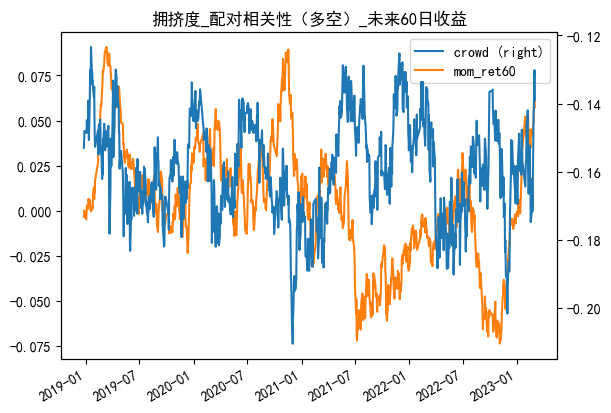

In [30]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_配对相关性（多空）_未来60日收益')

<Axes: title={'center': '拥挤度_特质收益率_配对相关性（多空）_分层收益'}, xlabel='crowd_group'>

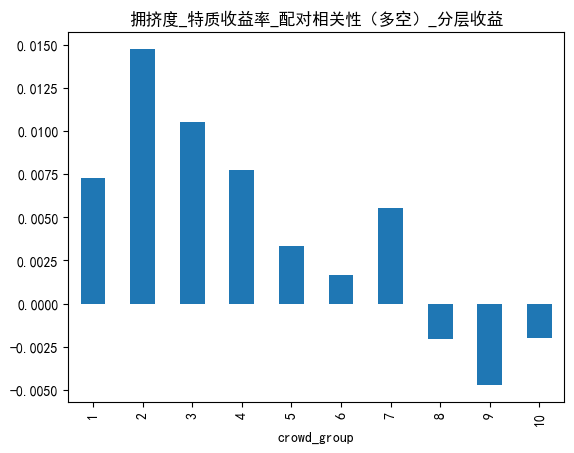

In [32]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_配对相关性（多空）_分层收益')

In [33]:
match_df = pd.DataFrame(match_dict).T
match_df['match'] = match_df['top']
match = - match_df['match']

match_z60 = ((match - match.rolling(60).mean())/match.rolling(60).std())
match_z120 = ((match - match.rolling(120).mean())/match.rolling(120).std())
match_z240 = ((match - match.rolling(240).mean())/match.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([match.to_frame('crowd'),-match_df['top'].to_frame('crowd_top'),-match_df['bottom'].to_frame('crowd_bottom'),match_z60.to_frame('crowd_z60'),match_z120.to_frame('crowd_z120'),match_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_top,crowd_bottom,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,1.000000,-0.126358,0.568573,0.739150,0.861517,0.234088,-0.265407,-0.398232
crowd_top,1.000000,1.000000,-0.126358,0.568573,0.739150,0.861517,0.234088,-0.265407,-0.398232
crowd_bottom,-0.126358,-0.126358,1.000000,0.144873,0.116913,0.141951,-0.245469,0.045639,0.168883
crowd_z60,0.568573,0.568573,0.144873,1.000000,0.886162,0.678840,0.182997,-0.077311,-0.211832
crowd_z120,0.739150,0.739150,0.116913,0.886162,1.000000,0.869566,0.185762,-0.180157,-0.335621
crowd_z240,0.861517,0.861517,0.141951,0.678840,0.869566,1.000000,0.058444,-0.201530,-0.246128
mon_cumret,0.234088,0.234088,-0.245469,0.182997,0.185762,0.058444,1.000000,-0.220319,-0.443381
mom_ret20,-0.265407,-0.265407,0.045639,-0.077311,-0.180157,-0.201530,-0.220319,1.000000,0.586361
mom_ret60,-0.398232,-0.398232,0.168883,-0.211832,-0.335621,-0.246128,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_特质收益率_配对相关性(多头)_分层收益'}, xlabel='crowd_group'>

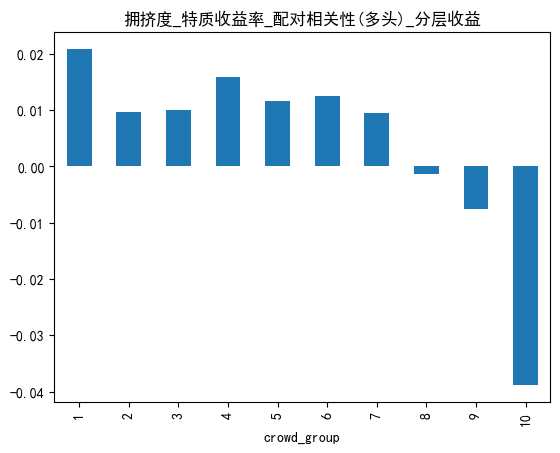

In [35]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd_top,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_配对相关性(多头)_分层收益')

In [36]:
match_df = pd.DataFrame(match_dict).T
match_df['match'] = match_df['bottom']
match = - match_df['match']

match_z60 = ((match - match.rolling(60).mean())/match.rolling(60).std())
match_z120 = ((match - match.rolling(120).mean())/match.rolling(120).std())
match_z240 = ((match - match.rolling(240).mean())/match.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([match.to_frame('crowd'),-match_df['top'].to_frame('crowd_top'),-match_df['bottom'].to_frame('crowd_bottom'),match_z60.to_frame('crowd_z60'),match_z120.to_frame('crowd_z120'),match_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_top,crowd_bottom,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,-0.126358,1.000000,0.653537,0.805147,0.890614,-0.245469,0.045639,0.168883
crowd_top,-0.126358,1.000000,-0.126358,0.082497,0.081478,-0.070169,0.234088,-0.265407,-0.398232
crowd_bottom,1.000000,-0.126358,1.000000,0.653537,0.805147,0.890614,-0.245469,0.045639,0.168883
crowd_z60,0.653537,0.082497,0.653537,1.000000,0.866087,0.736842,-0.064023,-0.040062,0.086316
crowd_z120,0.805147,0.081478,0.805147,0.866087,1.000000,0.901879,-0.089371,-0.018971,0.135477
crowd_z240,0.890614,-0.070169,0.890614,0.736842,0.901879,1.000000,-0.155088,-0.002913,0.140942
mon_cumret,-0.245469,0.234088,-0.245469,-0.064023,-0.089371,-0.155088,1.000000,-0.220319,-0.443381
mom_ret20,0.045639,-0.265407,0.045639,-0.040062,-0.018971,-0.002913,-0.220319,1.000000,0.586361
mom_ret60,0.168883,-0.398232,0.168883,0.086316,0.135477,0.140942,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_特质收益率_配对相关性(空头)_分层收益'}, xlabel='crowd_group'>

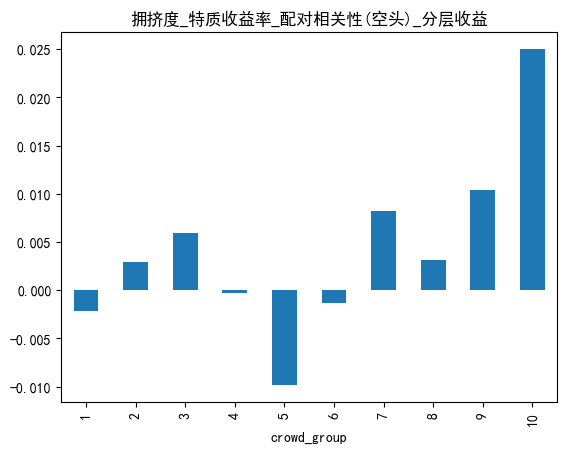

In [38]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd_bottom,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_配对相关性(空头)_分层收益')

In [39]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.9,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.1,axis = 1),axis = 0) > 0)

In [40]:
match_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,63)
    end_date_temp = i
    # 多头组配对相关性
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    top_ret60['mean'] = top_ret60.mean(axis = 1)
    top_match = top_ret60.corr()['mean'].drop('mean').mean()
    # 空头组配对相关性
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    bottom_ret60['mean'] = bottom_ret60.mean(axis = 1)
    bottom_match = bottom_ret60.corr()['mean'].drop('mean').mean()

    match_dict[i] = {'top':top_match,'bottom':bottom_match}

match_df = pd.DataFrame(match_dict).T

100%|██████████| 1314/1314 [00:03<00:00, 399.83it/s]


In [41]:
match_df = pd.DataFrame(match_dict).T
match_df['match'] = match_df['top'] + match_df['bottom']
match = - match_df['match']

match_z60 = ((match - match.rolling(60).mean())/match.rolling(60).std())
match_z120 = ((match - match.rolling(120).mean())/match.rolling(120).std())
match_z240 = ((match - match.rolling(240).mean())/match.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([match.to_frame('crowd'),-match_df['top'].to_frame('crowd_top'),-match_df['bottom'].to_frame('crowd_bottom'),match_z60.to_frame('crowd_z60'),match_z120.to_frame('crowd_z120'),match_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_top,crowd_bottom,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.755731,0.832446,0.481116,0.644032,0.744145,0.332896,-0.275580,-0.467115
crowd_top,0.755731,1.000000,0.266231,0.405840,0.559685,0.484530,-0.041197,-0.280644,-0.373947
crowd_bottom,0.832446,0.266231,1.000000,0.364758,0.474380,0.685325,0.524842,-0.168164,-0.371135
crowd_z60,0.481116,0.405840,0.364758,1.000000,0.815567,0.654356,-0.013220,0.046047,0.029489
crowd_z120,0.644032,0.559685,0.474380,0.815567,1.000000,0.878487,0.004828,-0.008062,-0.041437
crowd_z240,0.744145,0.484530,0.685325,0.654356,0.878487,1.000000,0.130091,-0.040197,-0.085376
mon_cumret,0.332896,-0.041197,0.524842,-0.013220,0.004828,0.130091,1.000000,-0.220319,-0.443381
mom_ret20,-0.275580,-0.280644,-0.168164,0.046047,-0.008062,-0.040197,-0.220319,1.000000,0.586361
mom_ret60,-0.467115,-0.373947,-0.371135,0.029489,-0.041437,-0.085376,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_配对相关性（多空）_未来60日收益'}>

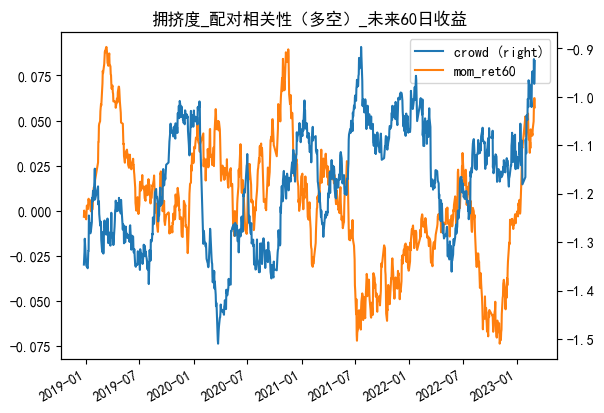

In [42]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_配对相关性（多空）_未来60日收益')

<Axes: title={'center': '拥挤度_配对相关性（多空）_分层收益'}, xlabel='crowd_group'>

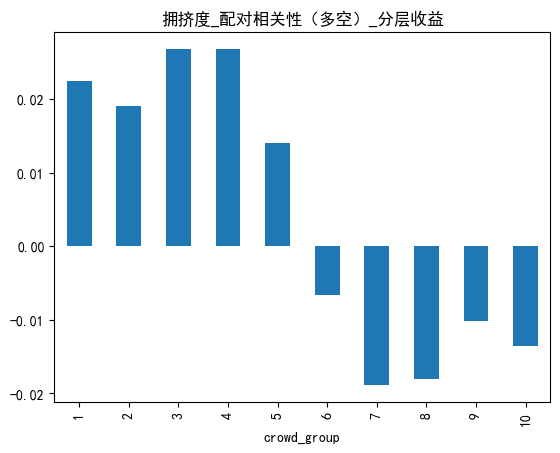

In [43]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_配对相关性（多空）_分层收益')

<Axes: title={'center': '拥挤度_配对相关性（多头）_未来60日收益'}>

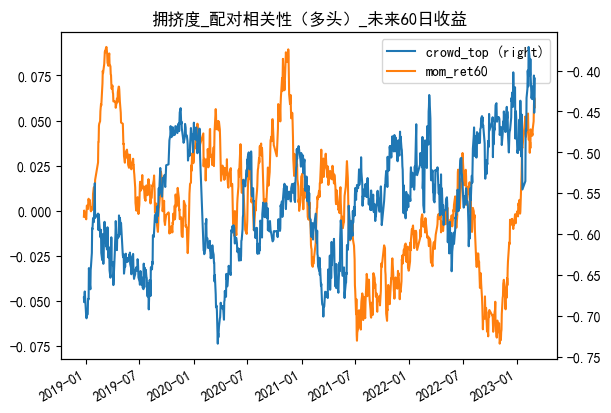

In [58]:
df[['crowd_top','mom_ret60']].plot(secondary_y='crowd_top',title = '拥挤度_配对相关性（多头）_未来60日收益')

<Axes: title={'center': '拥挤度_配对相关性(多头)_分层收益'}, xlabel='crowd_group'>

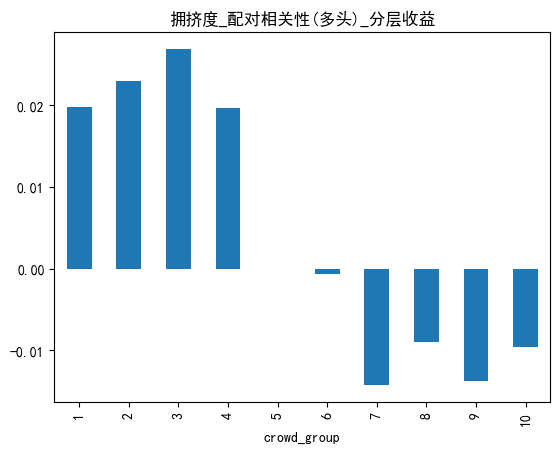

In [44]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd_top,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_配对相关性(多头)_分层收益')

<Axes: title={'center': '拥挤度_配对相关性（空头）_未来60日收益'}>

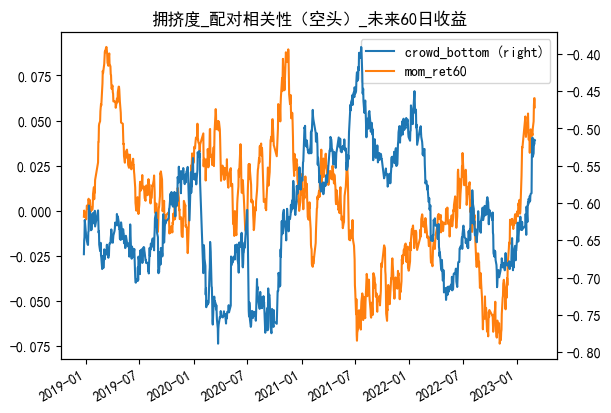

In [60]:
df[['crowd_bottom','mom_ret60']].plot(secondary_y='crowd_bottom',title = '拥挤度_配对相关性（空头）_未来60日收益')

<Axes: title={'center': '拥挤度_配对相关性（空头）_分层收益'}, xlabel='crowd_group'>

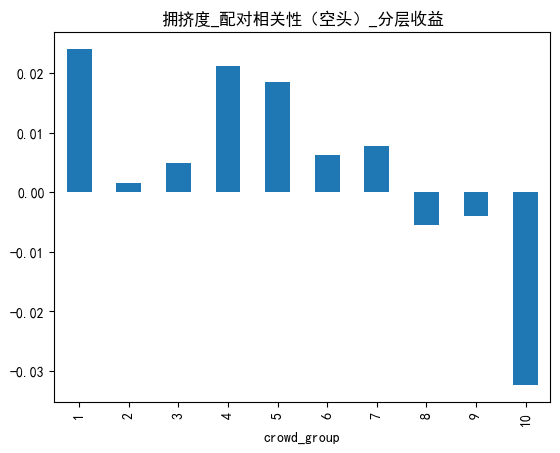

In [45]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd_bottom,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_配对相关性（空头）_分层收益')

##### （3）因子波动率

由于资金的流入会加剧因子收益率的波动，因此Bonne等(2018)从使用因子波动率衡量当前因子拥挤程度。本文中，在截面观测日回看3个月，将多空头组合内的成分股日收益等权，计算多空头组合的日收益，并计算多空头组合日收益序列的标准差。将历史时点上的A股市场上符合要求的股票等权组合，构建市场组合，用同样的方法计算市场组合的收益并计算标准差，因此期望相对波动率度量与因子波动率正相关。

+ 多头组合因子波动 = STD（多头组合）/STD（市场组合）

+ 多空组合因子波动 = STD（多空组合）/STD（市场组合）

The relative volatility metric measures the degree to which a factor’s expected volatility is unusually high or low for the given market environment. If large amounts of capital are following a factor, the swings in factor returns are likely to increase, particularly if the factor reaches a turning point or sentiment starts to shift. Specifically, our relative volatility metric is defined by the Barra USTMM forecast factor volatility divided by the forecast volatility for the market factor. We normalized by the current market volatility so that the metric measures expected factor volatility after accounting for general market volatility. We standardized the metric for each factor using a time-series framework with an expanding cumulative window at each point in time.

In [47]:
ret = get_price(stock_list,get_previous_trading_date(start_date,60),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')

In [48]:
specific_return = pd.read_pickle('data/specific_return.pkl')

##### 对比特质收益率和资产收益率

In [49]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.8,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.2,axis = 1),axis = 0) > 0)

In [64]:
std_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,60)
    end_date_temp = i
    # 多头组波动率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret60 = specific_return.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    top_ret60_std = top_ret60.mean(axis = 1).std()
    # 空头组波动率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret60 = specific_return.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_bottom_ret60_std = (top_ret60.mean(axis = 1) - bottom_ret60.mean(axis = 1)).std()
    # 市场组合收益率
    stock_list_temp = momentum.loc[i].dropna().index.tolist()
    ret60 = specific_return.loc[start_date_temp:end_date_temp][stock_list_temp]
    ret60_std = ret60.mean(axis = 1).std()

    std_dict[i] = {'top':top_ret60_std/ret60_std,'top_bottom':top_bottom_ret60_std/ret60_std}

100%|██████████| 1314/1314 [00:02<00:00, 513.34it/s]


In [51]:
std_df = pd.DataFrame(std_dict).T
std_top = std_df['top']


std_z60 = ((std_top - std_top.rolling(60).mean())/std_top.rolling(60).std())
std_z120 = ((std_top - std_top.rolling(120).mean())/std_top.rolling(120).std())
std_z240 = ((std_top - std_top.rolling(240).mean())/std_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.499571,0.638081,0.802293,-0.023994,0.503219,0.485449
crowd_z60,0.499571,1.000000,0.915727,0.732783,-0.306954,0.320532,0.326510
crowd_z120,0.638081,0.915727,1.000000,0.872954,-0.335096,0.410929,0.412639
crowd_z240,0.802293,0.732783,0.872954,1.000000,-0.293788,0.457812,0.402901
mon_cumret,-0.023994,-0.306954,-0.335096,-0.293788,1.000000,-0.220319,-0.443381
mom_ret20,0.503219,0.320532,0.410929,0.457812,-0.220319,1.000000,0.586361
mom_ret60,0.485449,0.326510,0.412639,0.402901,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_特质收益率_因子波动率（多头）_分层收益'}, xlabel='crowd_group'>

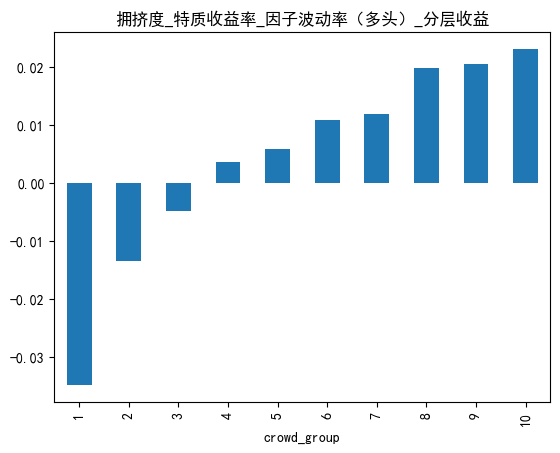

In [53]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_因子波动率（多头）_分层收益')

In [65]:
std_df = pd.DataFrame(std_dict).T
std_top_bottom = std_df['top_bottom']


std_z60 = ((std_top_bottom - std_top_bottom.rolling(60).mean())/std_top_bottom.rolling(60).std())
std_z120 = ((std_top_bottom - std_top_bottom.rolling(120).mean())/std_top_bottom.rolling(120).std())
std_z240 = ((std_top_bottom - std_top_bottom.rolling(240).mean())/std_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top_bottom.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.655918,0.816123,0.871269,-0.267906,0.355403,0.274653
crowd_z60,0.655918,1.000000,0.880889,0.791993,-0.076819,0.267082,0.155174
crowd_z120,0.816123,0.880889,1.000000,0.921809,-0.081090,0.244794,0.127938
crowd_z240,0.871269,0.791993,0.921809,1.000000,-0.172955,0.234018,0.062719
mon_cumret,-0.267906,-0.076819,-0.081090,-0.172955,1.000000,-0.220319,-0.443381
mom_ret20,0.355403,0.267082,0.244794,0.234018,-0.220319,1.000000,0.586361
mom_ret60,0.274653,0.155174,0.127938,0.062719,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_特质收益率_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

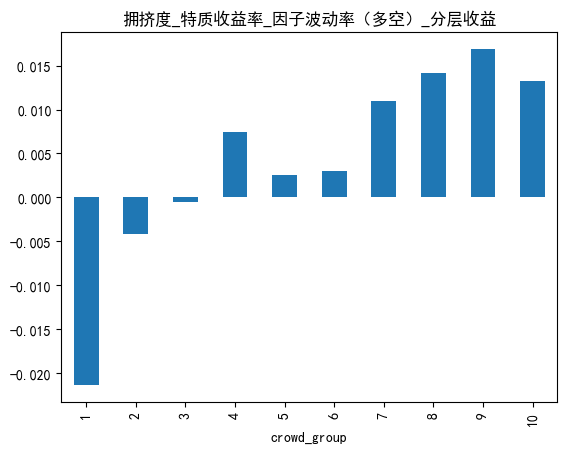

In [66]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_因子波动率（多空）_分层收益')

In [57]:
std_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,60)
    end_date_temp = i
    # 多头组波动率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    top_ret60_std = top_ret60.mean(axis = 1).std()
    # 空头组波动率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_bottom_ret60_std = (top_ret60.mean(axis = 1) - bottom_ret60.mean(axis = 1)).std()
    # 市场组合收益率
    stock_list_temp = momentum.loc[i].dropna().index.tolist()
    ret60 = ret.loc[start_date_temp:end_date_temp][stock_list_temp]
    ret60_std = ret60.mean(axis = 1).std()

    std_dict[i] = {'top':top_ret60_std/ret60_std,'top_bottom':top_bottom_ret60_std/ret60_std}

100%|██████████| 1314/1314 [00:02<00:00, 525.61it/s]


In [58]:
std_df = pd.DataFrame(std_dict).T
std_top = std_df['top']


std_z60 = ((std_top - std_top.rolling(60).mean())/std_top.rolling(60).std())
std_z120 = ((std_top - std_top.rolling(120).mean())/std_top.rolling(120).std())
std_z240 = ((std_top - std_top.rolling(240).mean())/std_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.266600,0.375455,0.552609,0.824922,-0.038167,-0.257489
crowd_z60,0.266600,1.000000,0.839983,0.677847,-0.008038,0.235097,0.342096
crowd_z120,0.375455,0.839983,1.000000,0.863972,0.115944,0.318652,0.327195
crowd_z240,0.552609,0.677847,0.863972,1.000000,0.391015,0.247148,0.240936
mon_cumret,0.824922,-0.008038,0.115944,0.391015,1.000000,-0.220319,-0.443381
mom_ret20,-0.038167,0.235097,0.318652,0.247148,-0.220319,1.000000,0.586361
mom_ret60,-0.257489,0.342096,0.327195,0.240936,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_因子波动率（多头）_分层收益'}>

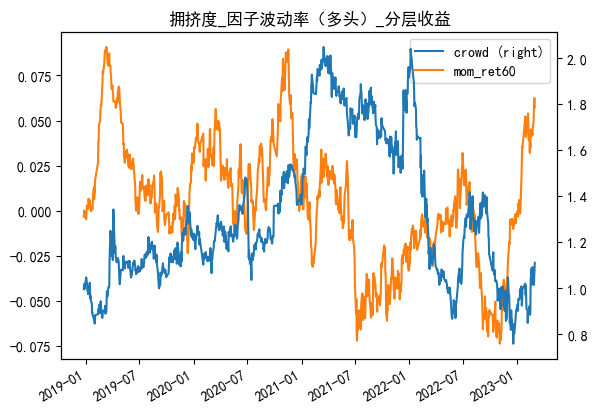

In [59]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子波动率（多头）_分层收益')

<Axes: title={'center': '拥挤度_因子波动率（多头）_分层收益'}, xlabel='crowd_group'>

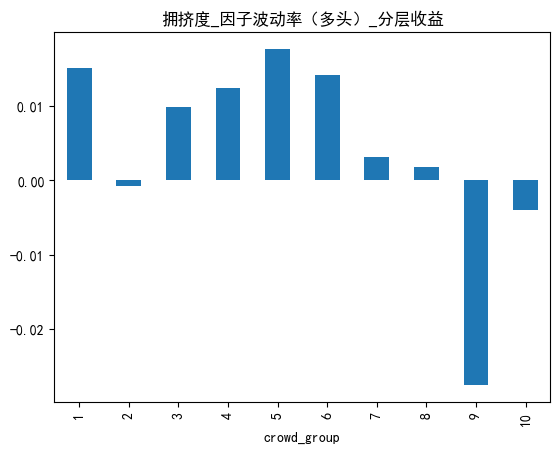

In [60]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多头）_分层收益')

In [61]:
std_df = pd.DataFrame(std_dict).T
std_top_bottom = std_df['top_bottom']


std_z60 = ((std_top_bottom - std_top_bottom.rolling(60).mean())/std_top_bottom.rolling(60).std())
std_z120 = ((std_top_bottom - std_top_bottom.rolling(120).mean())/std_top_bottom.rolling(120).std())
std_z240 = ((std_top_bottom - std_top_bottom.rolling(240).mean())/std_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([std_top_bottom.to_frame('crowd'),std_z60.to_frame('crowd_z60'),std_z120.to_frame('crowd_z120'),std_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.309631,0.473760,0.547228,0.718252,-0.271245,-0.499796
crowd_z60,0.309631,1.000000,0.837894,0.657121,0.156289,-0.030922,-0.032463
crowd_z120,0.473760,0.837894,1.000000,0.850730,0.249583,-0.029828,-0.092241
crowd_z240,0.547228,0.657121,0.850730,1.000000,0.447845,-0.022754,-0.044959
mon_cumret,0.718252,0.156289,0.249583,0.447845,1.000000,-0.220319,-0.443381
mom_ret20,-0.271245,-0.030922,-0.029828,-0.022754,-0.220319,1.000000,0.586361
mom_ret60,-0.499796,-0.032463,-0.092241,-0.044959,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_因子波动率（多空）_分层收益'}>

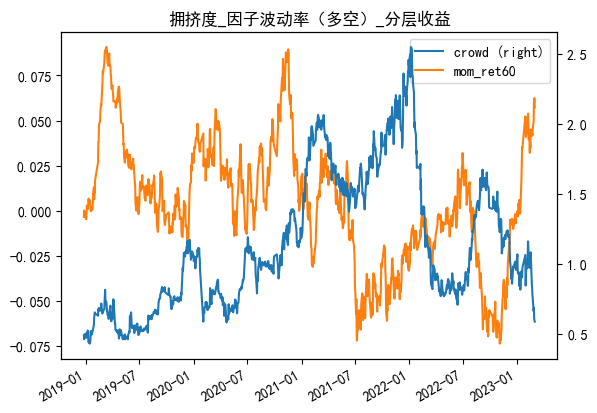

In [62]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子波动率（多空）_分层收益')

<Axes: title={'center': '拥挤度_因子波动率（多空）_分层收益'}, xlabel='crowd_group'>

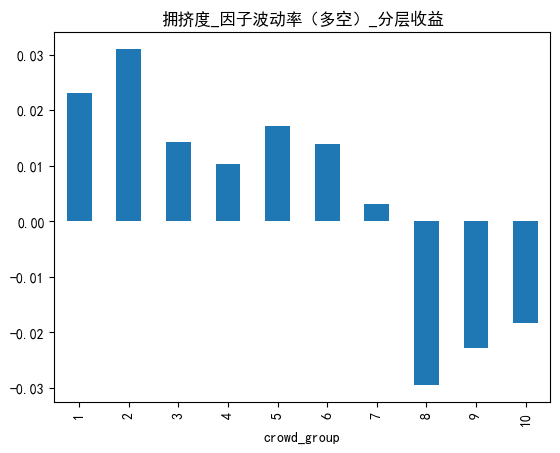

In [63]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子波动率（多空）_分层收益')

##### （4）因子反转

De Bondt等(1985) 表明美股在 3 到 5 年的中长期尺度上存在反转。由于投资者有追逐过去业绩的倾向，一个在一段时间内表现良好的因子可能已经积累了大量资本。这种性能追逐最初可能会为因子性能提供顺风，但最终可能会为视图或位置改变时的下降或均值回归奠定基础。异常强劲的表现通常不会永远持续下去。本文使用因子过去三年的累积收益率计算该指标。

+ 因子长期反转=Ret（因子多空组合近三年）

Because investors have a tendency to chase past performance, a factor that has done very well for some time is likely to have accumulated large amounts of capital. This performance chasing may initially provide a tailwind for factor performance, buteventually may set the stage for a drawdown or mean reversion when views or positioning change. Exceptionally strong performance does not typically last forever. For our factor reversal metric, we used a 3-year trailing window, which is consistent with the timeframe on which performance is evaluated for many funds. The phenomenon of long-term (3-5 year) reversal has been well known at the security level for some time (De Bondt and Thaler, 1985). Thus, our factor reversal metric is essentially the long-term reversal analog for factors. As with the other metrics, we standardized the factor reversal metric using a time-series framework. We standardized the raw trailing 3-year return for each factor using a factor-specific mean and global standard deviation (average standard deviation over all factors), employing an expanding cumulative window at each point in time.

In [74]:
ret = get_price(stock_list,get_previous_trading_date(start_date,252*3),end_date,fields = 'close').close.unstack('order_book_id').pct_change().dropna(how = 'all')

In [75]:
specific_return = pd.read_pickle('data/specific_return.pkl')

##### 对比特质收益率和资产收益率

In [76]:
momentum = barra_dict[barra_style[0]].mask(~index_fix)
momentum_top = momentum.mask((momentum.sub(momentum.quantile(0.8,axis = 1),axis = 0)) < 0)
momentum_bottom = momentum.mask(momentum.sub(momentum.quantile(0.2,axis = 1),axis = 0) > 0)

In [77]:
turn_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,252*3)
    end_date_temp = i
    # 多头组收益率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret756 = specific_return.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    # 空头组收益率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret756 = specific_return.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_ret756_value = (top_ret756.mean(axis = 1) + 1).cumprod()[-1] - 1
    top_bottom_ret756 = ((top_ret756.mean(axis = 1) - bottom_ret756.mean(axis = 1)) + 1).cumprod()[-1] - 1

    turn_dict[i] = {'top':top_ret756_value,'top_bottom':top_bottom_ret756}

100%|██████████| 1314/1314 [00:02<00:00, 618.28it/s]


In [78]:
turn_df = pd.DataFrame(turn_dict).T
turn_top_bottom = turn_df['top_bottom']


turn_z60 = ((turn_top_bottom - turn_top_bottom.rolling(60).mean())/turn_top_bottom.rolling(60).std())
turn_z120 = ((turn_top_bottom - turn_top_bottom.rolling(120).mean())/turn_top_bottom.rolling(120).std())
turn_z240 = ((turn_top_bottom - turn_top_bottom.rolling(240).mean())/turn_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top_bottom.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.491174,0.566989,0.629471,0.391509,0.180117,0.157776
crowd_z60,0.491174,1.000000,0.846974,0.671561,-0.051112,0.110890,0.048876
crowd_z120,0.566989,0.846974,1.000000,0.885863,-0.214135,0.114091,0.090853
crowd_z240,0.629471,0.671561,0.885863,1.000000,-0.366370,0.190293,0.300107
mon_cumret,0.391509,-0.051112,-0.214135,-0.366370,1.000000,-0.220319,-0.443381
mom_ret20,0.180117,0.110890,0.114091,0.190293,-0.220319,1.000000,0.586361
mom_ret60,0.157776,0.048876,0.090853,0.300107,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_特质收益率_因子反转（多空）_分层收益'}, xlabel='crowd_group'>

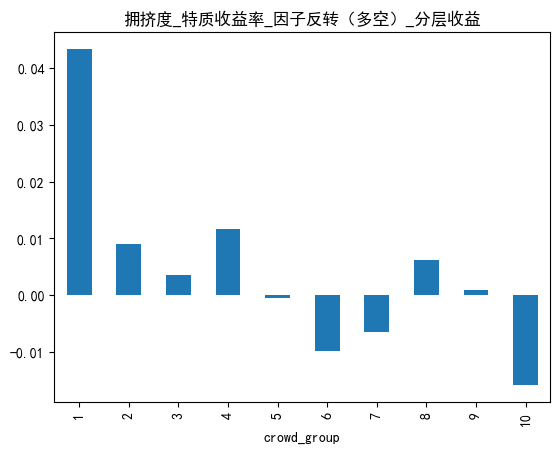

In [82]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_因子反转（多空）_分层收益')

In [83]:
turn_df = pd.DataFrame(turn_dict).T
turn_top = turn_df['top']


turn_z60 = ((turn_top - turn_top.rolling(60).mean())/turn_top.rolling(60).std())
turn_z120 = ((turn_top - turn_top.rolling(120).mean())/turn_top.rolling(120).std())
turn_z240 = ((turn_top - turn_top.rolling(240).mean())/turn_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.213917,0.164857,0.131973,0.646384,-0.093996,-0.340170
crowd_z60,0.213917,1.000000,0.852667,0.756922,-0.045809,0.154351,0.072590
crowd_z120,0.164857,0.852667,1.000000,0.924899,-0.201162,0.119821,0.088610
crowd_z240,0.131973,0.756922,0.924899,1.000000,-0.265037,0.203787,0.244378
mon_cumret,0.646384,-0.045809,-0.201162,-0.265037,1.000000,-0.220319,-0.443381
mom_ret20,-0.093996,0.154351,0.119821,0.203787,-0.220319,1.000000,0.586361
mom_ret60,-0.340170,0.072590,0.088610,0.244378,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_特质收益率_因子反转（多头）_分层收益'}, xlabel='crowd_group'>

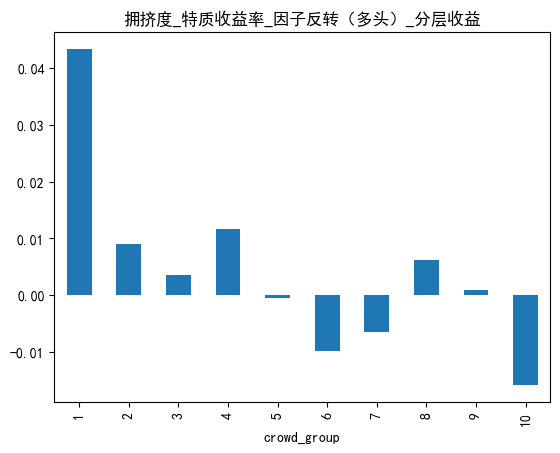

In [84]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_特质收益率_因子反转（多头）_分层收益')

In [85]:
turn_dict = {}

for i in tqdm(date_list):
    start_date_temp = get_previous_trading_date(i,252*3)
    end_date_temp = i
    # 多头组收益率
    stock_list_top_temp = momentum_top.loc[i].dropna().index.tolist()
    top_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_top_temp]
    # 空头组收益率
    stock_list_bottom_temp = momentum_bottom.loc[i].dropna().index.tolist()
    bottom_ret756 = ret.loc[start_date_temp:end_date_temp][stock_list_bottom_temp]
    top_ret756_value = (top_ret756.mean(axis = 1) + 1).cumprod()[-1] - 1
    top_bottom_ret756 = ((top_ret756.mean(axis = 1) - bottom_ret756.mean(axis = 1)) + 1).cumprod()[-1] - 1

    turn_dict[i] = {'top':top_ret756_value,'top_bottom':top_bottom_ret756}

100%|██████████| 1314/1314 [00:04<00:00, 326.05it/s]


In [86]:
turn_df = pd.DataFrame(turn_dict).T
turn_top_bottom = turn_df['top_bottom']


turn_z60 = ((turn_top_bottom - turn_top_bottom.rolling(60).mean())/turn_top_bottom.rolling(60).std())
turn_z120 = ((turn_top_bottom - turn_top_bottom.rolling(120).mean())/turn_top_bottom.rolling(120).std())
turn_z240 = ((turn_top_bottom - turn_top_bottom.rolling(240).mean())/turn_top_bottom.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top_bottom.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.329174,0.436301,0.639720,0.547528,0.058794,0.036047
crowd_z60,0.329174,1.000000,0.839847,0.647284,-0.071960,0.067879,0.024187
crowd_z120,0.436301,0.839847,1.000000,0.851897,-0.132545,0.021172,-0.015449
crowd_z240,0.639720,0.647284,0.851897,1.000000,-0.090247,0.049276,0.083367
mon_cumret,0.547528,-0.071960,-0.132545,-0.090247,1.000000,-0.220319,-0.443381
mom_ret20,0.058794,0.067879,0.021172,0.049276,-0.220319,1.000000,0.586361
mom_ret60,0.036047,0.024187,-0.015449,0.083367,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_因子反转（多空）_分层收益'}>

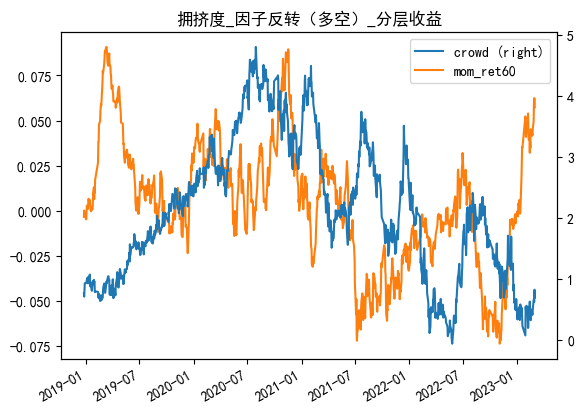

In [87]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多空）_分层收益')

<Axes: title={'center': '拥挤度_因子反转（多空）_分层收益'}, xlabel='crowd_group'>

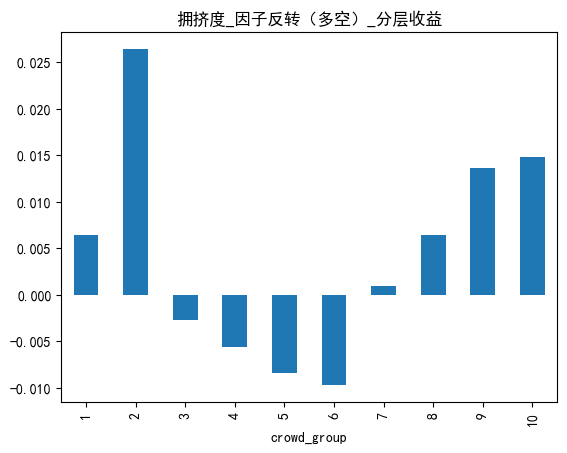

In [88]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子反转（多空）_分层收益')

In [89]:
turn_df = pd.DataFrame(turn_dict).T
turn_top = turn_df['top']


turn_z60 = ((turn_top - turn_top.rolling(60).mean())/turn_top.rolling(60).std())
turn_z120 = ((turn_top - turn_top.rolling(120).mean())/turn_top.rolling(120).std())
turn_z240 = ((turn_top - turn_top.rolling(240).mean())/turn_top.rolling(240).std())
mon_cumret = (barra_return['momentum']+1).cumprod()
mom_ret20 = barra_return['momentum'].rolling(20).sum().shift(-20)
mom_ret60 = barra_return['momentum'].rolling(60).sum().shift(-60)

df = pd.concat([turn_top.to_frame('crowd'),turn_z60.to_frame('crowd_z60'),turn_z120.to_frame('crowd_z120'),turn_z240.to_frame('crowd_z240'),mon_cumret.to_frame('mon_cumret'),mom_ret20.to_frame('mom_ret20'),mom_ret60.to_frame('mom_ret60')],axis = 1).dropna()

df.corr()

,crowd,crowd_z60,crowd_z120,crowd_z240,mon_cumret,mom_ret20,mom_ret60
crowd,1.000000,0.260407,0.350244,0.411798,0.667455,-0.176865,-0.401651
crowd_z60,0.260407,1.000000,0.845758,0.682882,-0.012895,0.096122,0.113513
crowd_z120,0.350244,0.845758,1.000000,0.900291,-0.032724,0.061369,0.068247
crowd_z240,0.411798,0.682882,0.900291,1.000000,0.063851,0.089725,0.080098
mon_cumret,0.667455,-0.012895,-0.032724,0.063851,1.000000,-0.220319,-0.443381
mom_ret20,-0.176865,0.096122,0.061369,0.089725,-0.220319,1.000000,0.586361
mom_ret60,-0.401651,0.113513,0.068247,0.080098,-0.443381,0.586361,1.000000


<Axes: title={'center': '拥挤度_因子反转（多头）_分层收益'}>

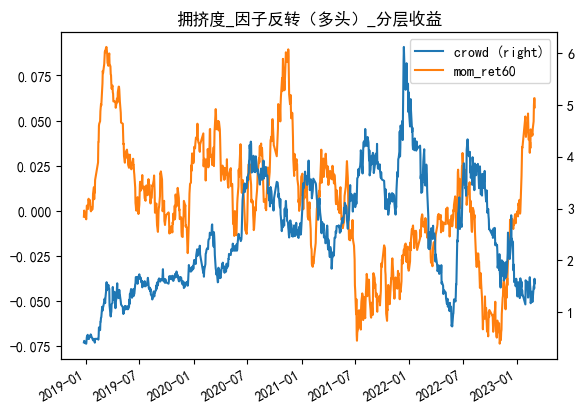

In [90]:
df[['crowd','mom_ret60']].plot(secondary_y='crowd',title = '拥挤度_因子反转（多头）_分层收益')

<Axes: title={'center': '拥挤度_因子反转（多头）_分层收益'}, xlabel='crowd_group'>

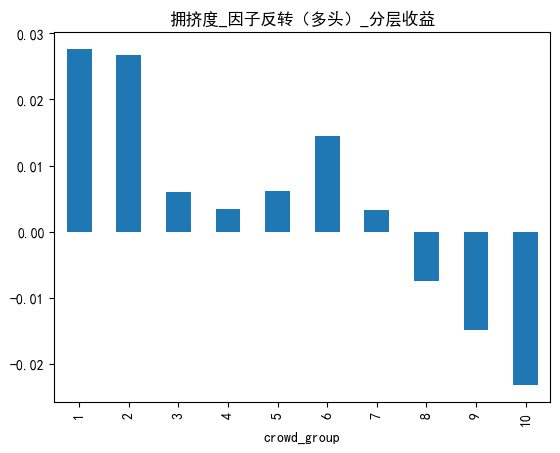

In [91]:
g = 10
df['crowd_group'] = pd.qcut(df.crowd,g, list(range(1,g+1))).to_list()
df.groupby(['crowd_group']).mom_ret60.mean().plot(kind = 'bar',title = '拥挤度_因子反转（多头）_分层收益')